# Bayesian Optimization for estimating Noise in the Objective function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from GPyOpt.methods import BayesianOptimization
import seaborn
plt.style.use('seaborn-notebook')

In [2]:
def f(x):
    return x**2 + np.random.normal(0.0, 1.0)

### Test the objective function

In [3]:
x = np.random.choice(np.linspace(-10, 10, 100), 200)
y = [f(i) for i in x]

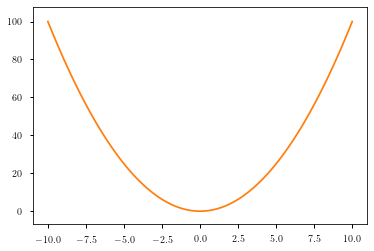

In [4]:
plt.plot(x, y, 'x')
plt.plot(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100)**2)

Objective function looks about right.

In [5]:
# Define gpopt
domain = [{"name": "var_1", "type": "continuous", "domain": (-10.0, 10.0)}]

myBopt = BayesianOptimization(
    f=f,
    domain=domain,
    model_type="GP",
    acquisition_type="EI",
    acquisition_weight=1,
    initial_design_numdata=1,
)

In [6]:
log = myBopt.run_optimization(path_to_save='./',
                              max_iter=100,
                              save_inter_models=False)

In [7]:
myBopt.x_opt

array([-0.10092962])

In [8]:
def plot_acquisition(axis, model):
    bounds = model.acquisition.space.get_bounds()

    x_grid = np.arange(bounds[0][0], bounds[0][1], 0.001)
    x_grid = x_grid.reshape(len(x_grid), 1)
    # acqu = model.acquisition.acquisition_function(x_grid)
    # acqu_normalized = (-acqu - min(-acqu)) / (max(-acqu - min(-acqu)))
    m, v = model.model.predict(x_grid)
    factor = max(m + 1.96 * np.sqrt(v)) - min(m - 1.96 * np.sqrt(v))
    axis.plot(x_grid, m, color="#D5313E", lw=2.0)
    axis.plot(x_grid, m - 1.96 * np.sqrt(v), color="#445792")
    axis.plot(x_grid, m + 1.96 * np.sqrt(v), color="#445792")
    axis.fill_between(
        np.ravel(x_grid),
        np.ravel(m - 1.96 * np.sqrt(v)),
        np.ravel(m + 1.96 * np.sqrt(v)),
        color="#445792",
        alpha=0.5,
    )
    y = model.Y - model.Y.mean()
    y = y / model.Y.std()
    axis.scatter(model.X[:-1], y[:-1], color="#9F383E", marker="o")

    axis.set_xlabel("Valve Setting")
    axis.set_ylabel("Objective")
    axis.set_ylim(
        min(m - 1.96 * np.sqrt(v)) - 0.25 * factor,
        max(m + 1.96 * np.sqrt(v)) + 0.05 * factor,
    )

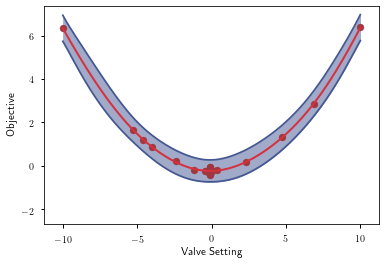

In [9]:
ax = plt.subplot(1, 1, 1)
plot_acquisition(ax, myBopt)

In [10]:
myBopt.model.get_model_parameters_names()

['GP_regression.Mat52.variance',
 'GP_regression.Mat52.lengthscale',
 'GP_regression.Gaussian_noise.variance']

In [11]:
myBopt.model.get_model_parameters()

array([[1.33799834e+03, 4.31202451e+01, 4.36715435e-03]])

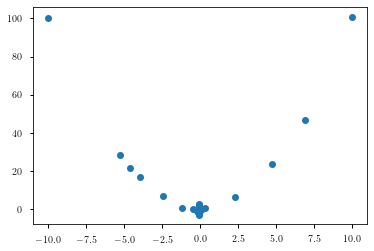

In [12]:
plt.plot(myBopt.X, myBopt.Y, 'o')

Uncertanity estimates are off. Let us define a custom GP model so that we can see all the internal mechanics.

## Modular Bayesian Optimization

In [373]:
import GPyOpt
import GPy

In [472]:
class ObjectiveFunction:
    def __init__(self, noise_mean, noise_variance):
        self.n_mu = noise_mean
        self.n_var = noise_variance
        
    def f(self, x):
        return 3.0*np.sin(np.pi*x) - np.random.normal(self.n_mu, self.n_var)
f_temp = ObjectiveFunction(0.0, 2.0)
objective = GPyOpt.core.task.SingleObjective(f_temp.f)

`GPyOpt` model structure requires the components of the BO to be declared as classes.
The above is the structure of the the objective function class.

In [473]:
search_space = GPyOpt.Design_space(space=[{"name": "var_1", "type": "continuous", "domain": (-1.0, 1.0)}])

Design a custom Gaussian Process Model

In [474]:
# Create a sum of kernel
kernel_sum = GPy.kern.RBF(1) + GPy.kern.White(1)

In [475]:
model = GPyOpt.models.GPModel(kernel=kernel_sum,
                              noise_var=0.0, # how does one pick this? is this updated?
                              optimize_restarts=5,
                              verbose=False)

Gaussian models follow `GPy` structure. This enables us to design specific kernels.

In [476]:
initial_design = GPyOpt.experiment_design.initial_design('random', search_space, 5)

Choose the initial sampling effort.

In [477]:
acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(search_space)
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, search_space, acq_optimizer)

In [478]:
# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [479]:
bo = GPyOpt.methods.ModularBayesianOptimization(model,
                                                search_space,
                                                objective,
                                                acquisition,
                                                evaluator, 
                                                initial_design)

In [480]:
max_iter  = 100                                         
bo.run_optimization(path_to_save="./", max_iter = max_iter) 

In [481]:
bo.x_opt

array([-0.3376195])

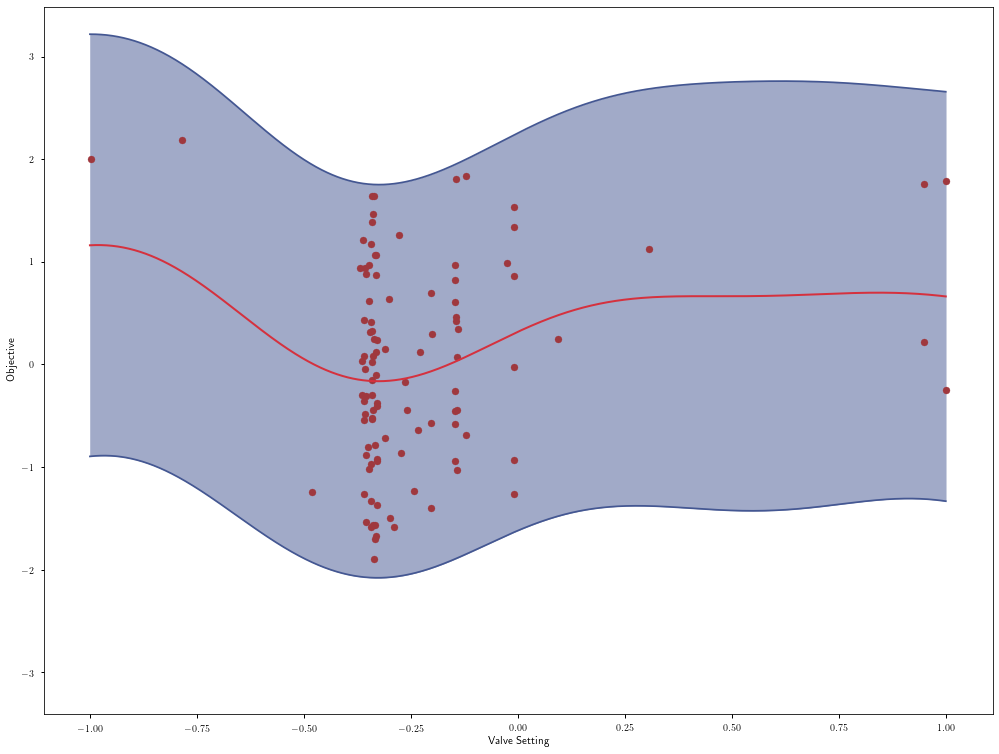

In [482]:
ax = plt.subplot(1, 1, 1)
plot_acquisition(ax, bo)

In [483]:
print(bo.model.model)


Name : GP regression
Objective : 148.08803406884715
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |    constraints    |  priors
  sum.rbf.variance         |     0.6782350589053083  |        +ve        |        
  sum.rbf.lengthscale      |    0.34355193913195525  |        +ve        |        
  sum.white.variance       |     0.9016535781524285  |        +ve        |        
  Gaussian_noise.variance  |  9.768732054963168e-05  |  1e-09,1000000.0  |        


In [484]:
x_grid = np.arange(-1.0, 1.0, 0.1)
x_grid = x_grid.reshape(len(x_grid), 1)
m, v = model.model.predict(x_grid)

(0, array([1.4235881]))

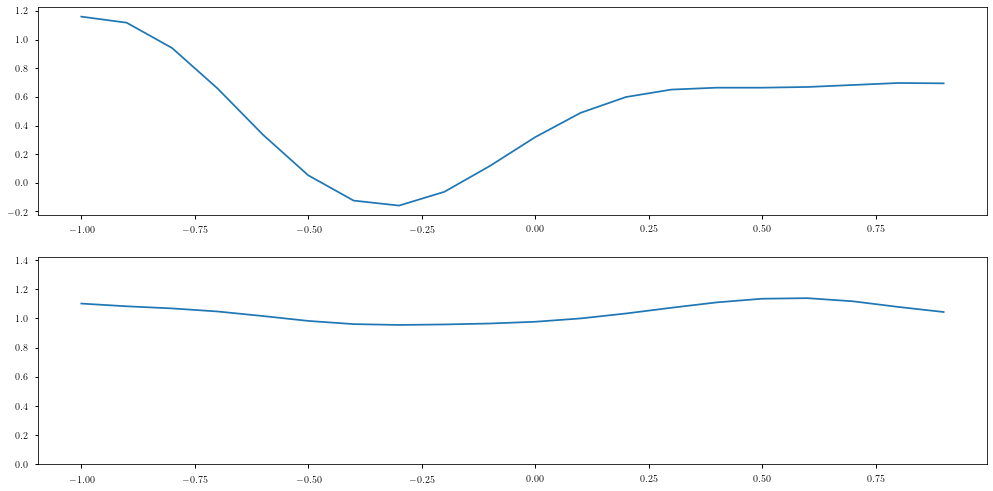

In [485]:
plt.rcParams["figure.figsize"] = (17,13)
plt.subplot(3,1,1)
plt.plot(x_grid, m)
plt.subplot(3,1,2)
plt.plot(x_grid, np.sqrt(v))
plt.ylim(0, max(np.sqrt(v))*1.25)

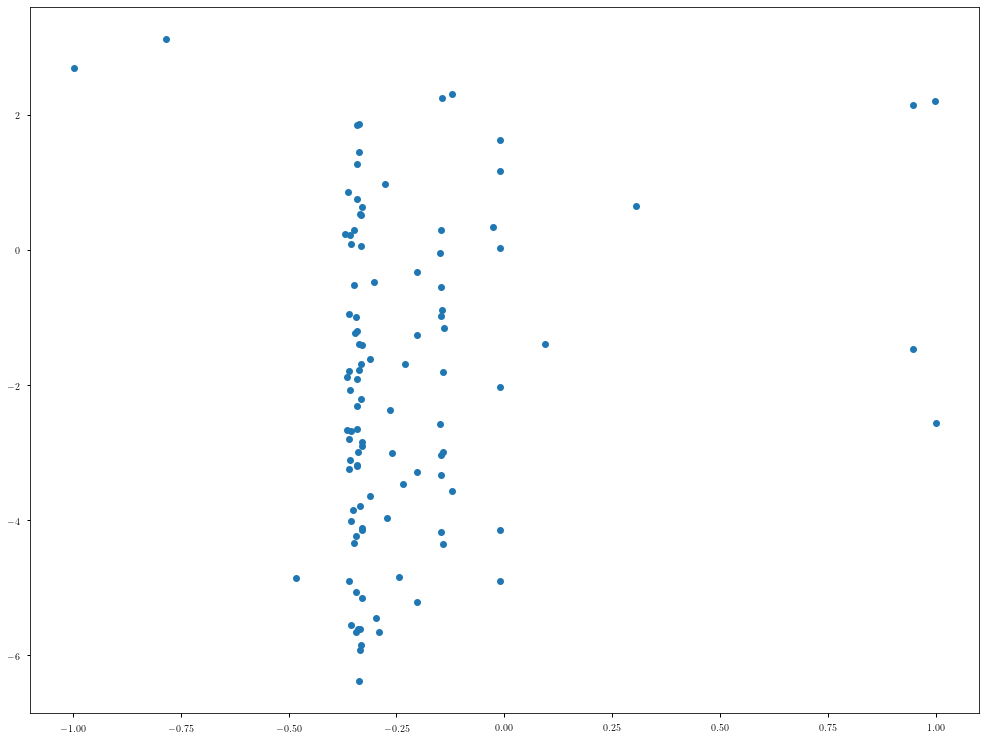

In [486]:
plt.plot(bo.X, bo.Y, 'o')

There are multiple things that are happening here.

What ever the objective function is, when you are trying to learn it from just data. You will not always be able to sucessfully get the perfect noise term out. Because the Bayopt has way of knowing what is the perfect noise. But rather, you can recover some information about the noise. Using variance, you can estimate the level of uncertanity associated with taking that action relative to the other choices you are presented. 

## Let us take a look at multiple dimensions

In [519]:
class ObjectiveFunction:
    def __init__(self, noise_mean, noise_variance):
        self.n_mu = noise_mean
        self.n_var = noise_variance
        
    def f(self, x):
        return 4.0*np.sin(np.pi*x[0][0]) - 4.0*np.cos(np.pi*x[0][1]) + np.random.normal(self.n_mu, self.n_var)

In [526]:
f_temp = ObjectiveFunction(0.0, 2.0)
x_grid = np.arange(-1.0, 1.0, 0.01)
x_grid = x_grid.reshape(len(x_grid), 1)
y_grid = np.arange(-1.0, 1.0, 0.01)
y_grid = x_grid.reshape(len(x_grid), 1)
Z = np.zeros((len(x_grid), len(y_grid)))
X = np.zeros((len(x_grid), len(y_grid)))
Y = np.zeros((len(x_grid), len(y_grid)))
for i in range(0, len(x_grid)):
    for j in range(0, len(y_grid)):
        Z[i,j] = f_temp.f([[x_grid[i], y_grid[j]]])
        X[i,j] = x_grid[i]
        Y[i,j] = y_grid[j]

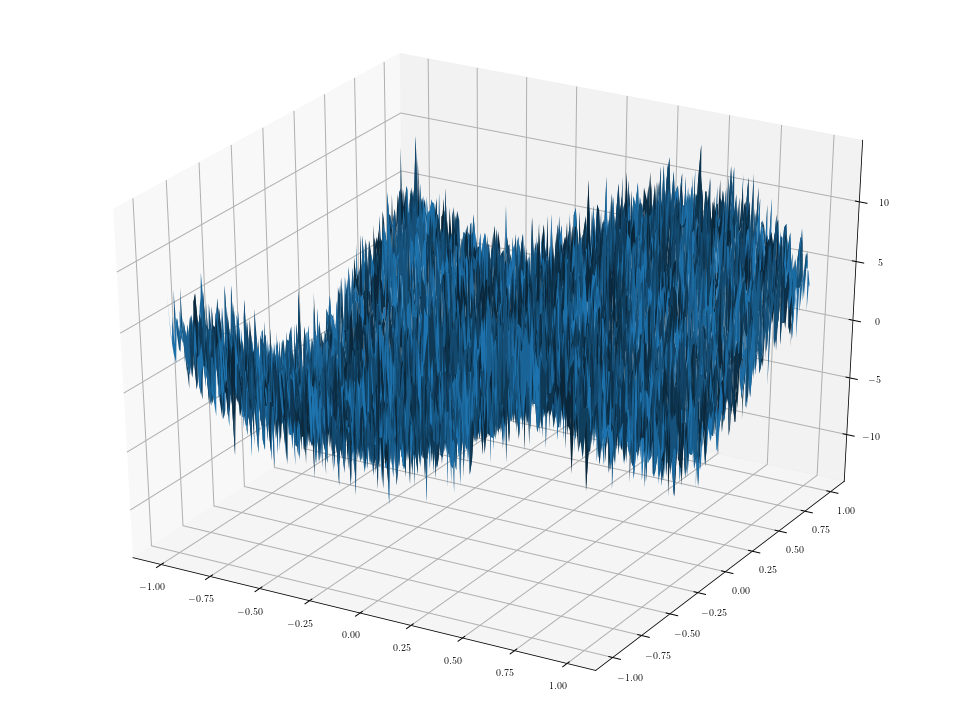

In [527]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=X, Y=Y, Z=Z)

In [529]:
f_temp = ObjectiveFunction(0.0, 2.0)
objective = GPyOpt.core.task.SingleObjective(f_temp.f)
search_space = GPyOpt.Design_space(space=[{"name": "var_1", "type": "continuous", "domain": (-1.0, 1.0)},
                                         {"name": "var_2", "type": "continuous", "domain": (-1.0, 1.0)}])
# Create a sum of kernel
kernel_sum = GPy.kern.RBF(2) + GPy.kern.White(2)
model = GPyOpt.models.GPModel(kernel=kernel_sum,
                              noise_var=0.0, # how does one pick this? is this updated?
                              optimize_restarts=5,
                              verbose=False)
initial_design = GPyOpt.experiment_design.initial_design('random', search_space, 5)
acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(search_space)
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, search_space, acq_optimizer)
# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = GPyOpt.methods.ModularBayesianOptimization(model,
                                                search_space,
                                                objective,
                                                acquisition,
                                                evaluator, 
                                                initial_design)
max_iter  = 100                                         
bo.run_optimization(path_to_save="./", max_iter = max_iter) 

In [538]:
bo.x_opt.shape

(2,)

In [532]:
print(bo.model.model)


Name : GP regression
Objective : 115.56170531266984
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |    constraints    |  priors
  sum.rbf.variance         |       8.993746349176492  |        +ve        |        
  sum.rbf.lengthscale      |      0.8615584220188993  |        +ve        |        
  sum.white.variance       |      0.4060518773222711  |        +ve        |        
  Gaussian_noise.variance  |  0.00015140582908150613  |  1e-09,1000000.0  |        


In [539]:
x_grid = np.arange(-1.0, 1.0, 0.01)
x_grid = x_grid.reshape(len(x_grid), 1)
y_grid = np.arange(-1.0, 1.0, 0.01)
y_grid = x_grid.reshape(len(x_grid), 1)
Z = np.zeros((len(x_grid), len(y_grid)))
X = np.zeros((len(x_grid), len(y_grid)))
Y = np.zeros((len(x_grid), len(y_grid)))
for i in range(0, len(x_grid)):
    for j in range(0, len(y_grid)):
        Z[i,j] = bo.model.predict_covariance(np.array([x_grid[i], y_grid[j]]).reshape(2,))
        X[i,j] = x_grid[i]
        Y[i,j] = y_grid[j]

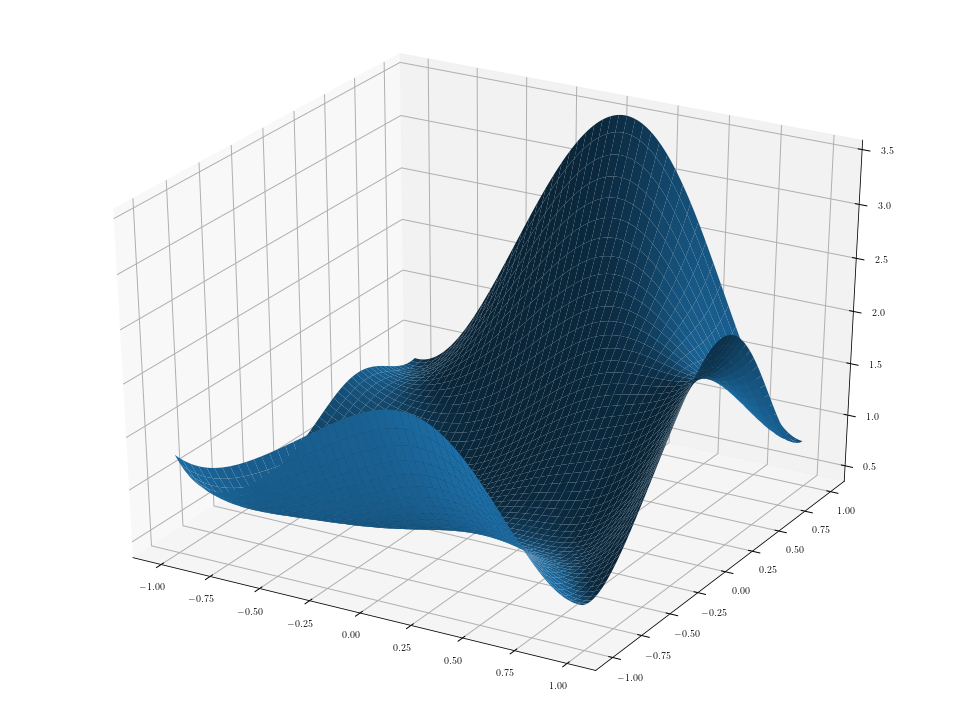

In [540]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=X, Y=Y, Z=Z)

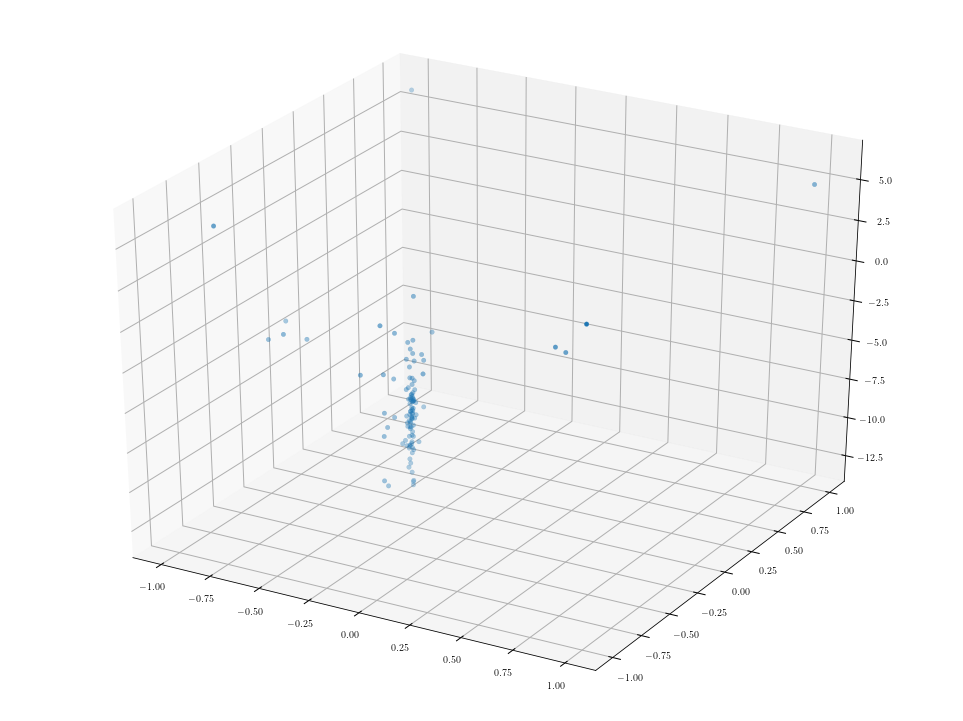

In [553]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bo.X[:,0], bo.X[:,1], bo.Y)

## How will you visuvalize uncertanity when you have more than 2 axis?

In [554]:
class ObjectiveFunction:
    def __init__(self, noise_mean, noise_variance):
        self.n_mu = noise_mean
        self.n_var = noise_variance
        
    def f(self, x):
        return 4.0*np.sin(np.pi*x[0][0]) + 4.0*np.sin(np.pi*x[0][1]) + 4.0*np.sin(np.pi*x[0][2]) + np.random.normal(self.n_mu, self.n_var)

In [564]:
f_temp = ObjectiveFunction(0.0, 2.0)
objective = GPyOpt.core.task.SingleObjective(f_temp.f)
search_space = GPyOpt.Design_space(space=[{"name": "var_1", "type": "continuous", "domain": (-1.0, 1.0)},
                                         {"name": "var_2", "type": "continuous", "domain": (-1.0, 1.0)},
                                         {"name": "var_2", "type": "continuous", "domain": (-1.0, 1.0)}])
# Create a sum of kernel
kernel_sum = GPy.kern.RBF(3) + GPy.kern.White(3)
model = GPyOpt.models.GPModel(kernel=kernel_sum,
                              noise_var=0.0, # how does one pick this? is this updated?
                              optimize_restarts=5,
                              verbose=False)
initial_design = GPyOpt.experiment_design.initial_design('random', search_space, 5)
acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(search_space)
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, search_space, acq_optimizer)
# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = GPyOpt.methods.ModularBayesianOptimization(model,
                                                search_space,
                                                objective,
                                                acquisition,
                                                evaluator, 
                                                initial_design)
max_iter  = 100                                         
bo.run_optimization(path_to_save="./", max_iter = max_iter) 

In [565]:
bo.x_opt

array([-0.40298016, -0.34554034, -0.40907399])

In [566]:
bo.model.predict_covariance(bo.x_opt)

array([[0.23093815]])

In [567]:
bo.model.model.kern.K(bo.X)

array([[3.70762798, 2.60206896, 0.01975592, ..., 2.67991234, 2.67829553,
        2.67897529],
       [2.60206896, 3.70762798, 0.01447008, ..., 2.08774599, 2.09420343,
        2.09605622],
       [0.01975592, 0.01447008, 3.70762798, ..., 0.06810009, 0.06722351,
        0.0667666 ],
       ...,
       [2.67991234, 2.08774599, 0.06810009, ..., 3.70762798, 3.48181686,
        3.48174463],
       [2.67829553, 2.09420343, 0.06722351, ..., 3.48181686, 3.70762798,
        3.48189539],
       [2.67897529, 2.09605622, 0.0667666 , ..., 3.48174463, 3.48189539,
        3.70762798]])

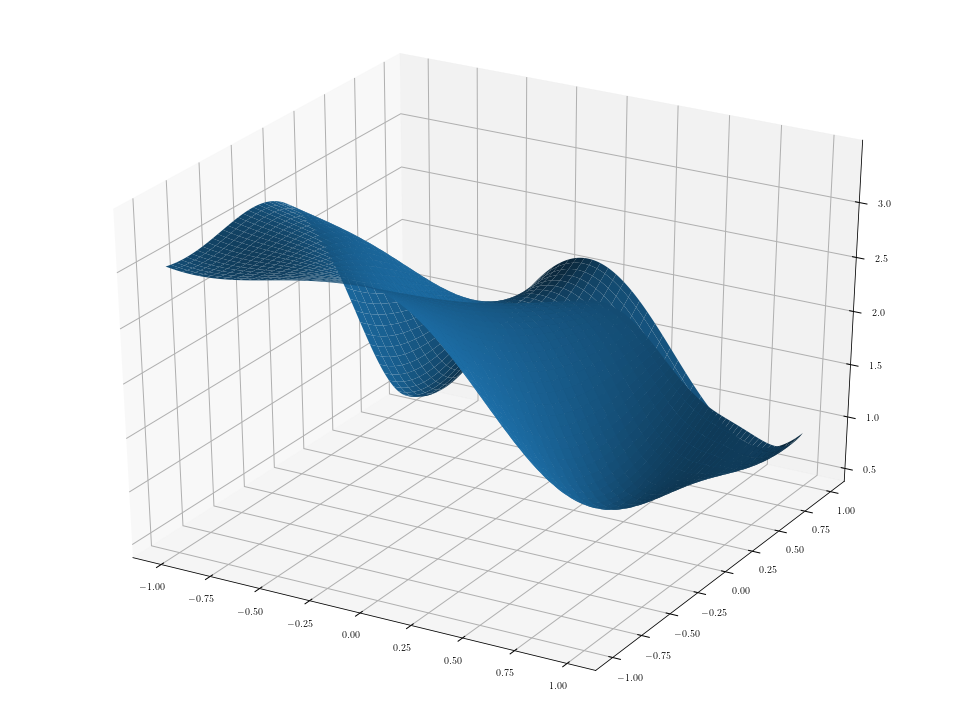

In [570]:
x_grid = np.arange(-1.0, 1.0, 0.01)
x_grid = x_grid.reshape(len(x_grid), 1)
y_grid = np.arange(-1.0, 1.0, 0.01)
y_grid = x_grid.reshape(len(x_grid), 1)
Z = np.zeros((len(x_grid), len(y_grid)))
X = np.zeros((len(x_grid), len(y_grid)))
Y = np.zeros((len(x_grid), len(y_grid)))
for i in range(0, len(x_grid)):
    for j in range(0, len(y_grid)):
        Z[i,j] = bo.model.predict_covariance(np.array([x_grid[i], y_grid[j], 1.0]).reshape(3,))
        X[i,j] = x_grid[i]
        Y[i,j] = y_grid[j]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=X, Y=Y, Z=Z)